# Color segmentation: 
Given an RGB color image of size n = w \* h pixels,each pixel can be viewed as a three dimensional feature, each dimension describes the value in each color channel. For the task of image segmentation, please run the k-means algorithm\* to cluster these n pixels (in terms of their 3D features) into k groups.
    
(i) Plot the segmentation results for both images based on your clustering results. For
visualization purposes, pixels in the same group should be represented by the same
color, while those in dierent groups are shown in distinct colors, as shown in Fig. 1a.
    
(ii) Convert both RGB images into Lab color space. Repeat the above clustering pro-
cedure and plot your segmentation results.
(*Please use k = 10 and maximum number of iterations = 1000 for both zebra.jpg
and mountain.jpg when running the k-means algorithm.)

In [1]:
import os
import numpy as np

from matplotlib import pyplot as plt
from skimage import io as image_io
from skimage import color as image_color
from scipy import io as sio

from sklearn.cluster import KMeans

from multiprocessing import Manager , Process

data_root = "../data/hw2_dataset/Problem2"

os.listdir(data_root)

['filterBank.mat', 'mountain.jpg', 'zebra.jpg']

Import data image


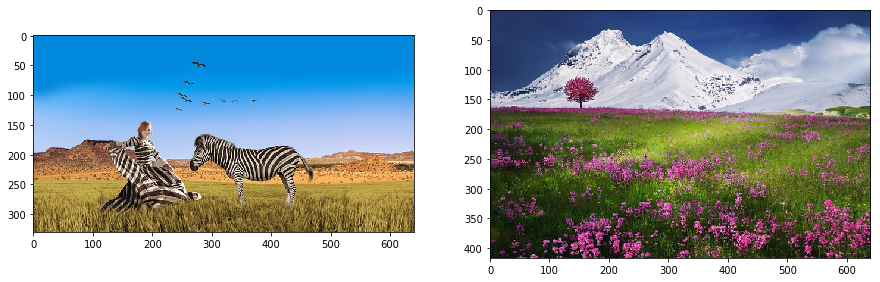

In [2]:
filterBank = sio.loadmat( os.path.join( data_root , "filterBank.mat" ) )["F"]

mountain = image_io.imread( os.path.join( data_root , "mountain.jpg" ) )
zebra = image_io.imread( os.path.join( data_root , "zebra.jpg" ) )
print("Import data image")


fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(1,2,1)
ax.imshow(zebra)
ax1 = fig.add_subplot(1,2,2)
ax1.imshow( mountain )
plt.show()

### (i) Use kmeans to clust original image by RGB

In [3]:
def produce_pixel_label( img,n_cluster = 10 , size=3):
    arr=img.reshape(-1,size)
    n_iter = 1000
    km = KMeans(n_cluster, max_iter=n_iter , n_jobs=4)
    return km.fit_predict( arr ).reshape(img.shape[0:2])

In [4]:
mountain_cluster = produce_pixel_label( mountain )
zebra_cluster = produce_pixel_label( zebra )

print("Finish kmeans")

Finish kmeans


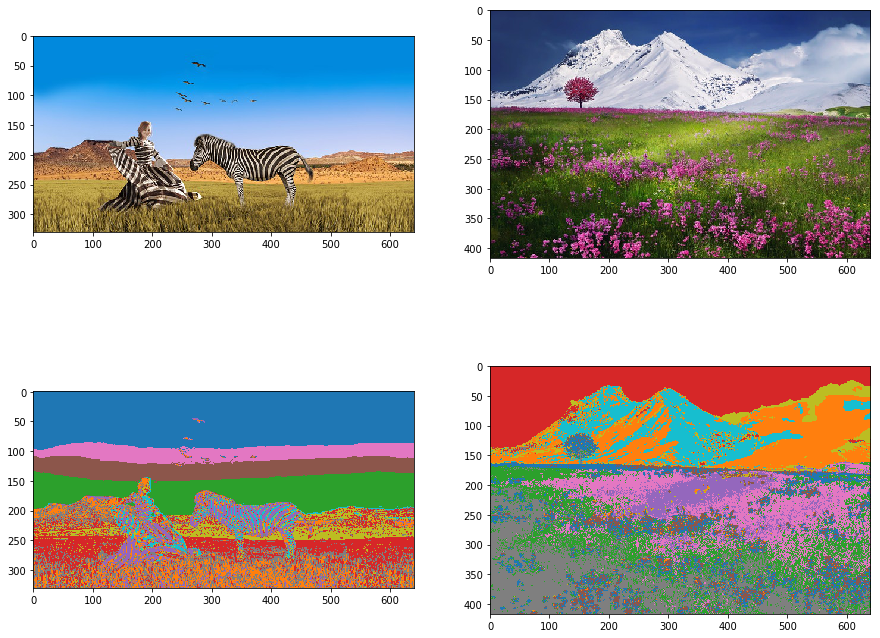

In [5]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(2,2,1)
ax.imshow(zebra)
ax1 = fig.add_subplot(2,2,2)
ax1.imshow( mountain )
ax2 = fig.add_subplot(2,2,3)
ax2.imshow( zebra_cluster , cmap="tab10" )
ax2 = fig.add_subplot(2,2,4)
ax2.imshow( mountain_cluster , cmap="tab10")
plt.show()

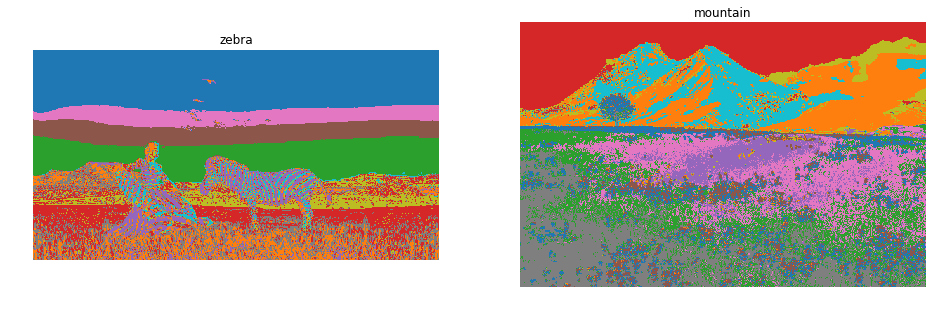

In [27]:
fig = plt.figure(figsize=(16,6))
ax2 = fig.add_subplot(1,2,1)
ax2.imshow( zebra_cluster , cmap="tab10" )
ax2.set_title("zebra")
ax2.axis("off")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow( mountain_cluster , cmap="tab10")
ax2.set_title("mountain")
ax2.axis("off")
plt.savefig("2-a-1.png")
plt.show()

### (ii) Use kmeans to clust original image by Lab

In [6]:
lab_mountain = image_color.rgb2lab(mountain)
lab_zebra = image_color.rgb2lab(zebra)

lab_mountain_cluster = produce_pixel_label(lab_mountain)
lab_zebra_cluster = produce_pixel_label( lab_zebra )
print("Finish kmeans on Lab color")

Finish kmeans on Lab color


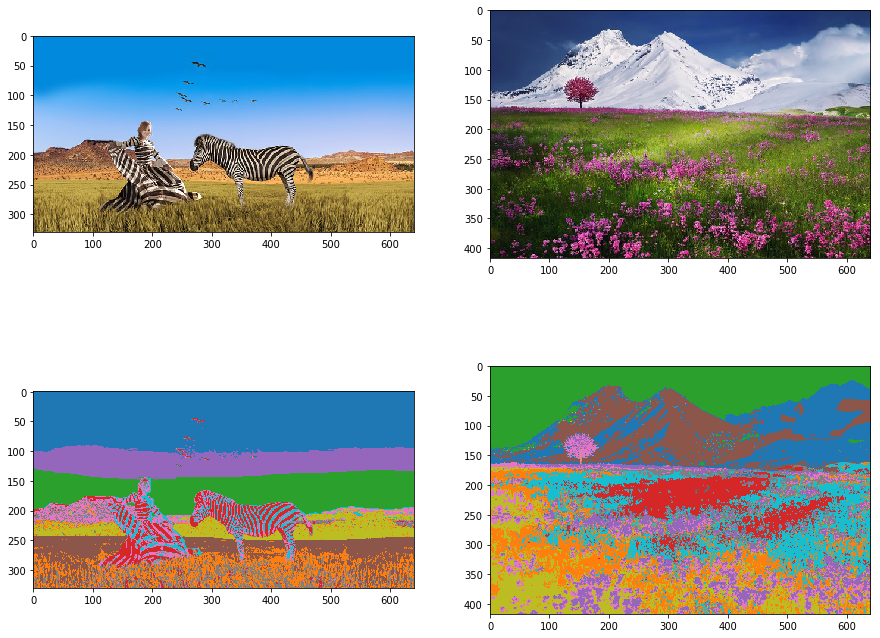

In [7]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(2,2,1)
ax.imshow(zebra)
ax1 = fig.add_subplot(2,2,2)
ax1.imshow( mountain )
ax2 = fig.add_subplot(2,2,3)
ax2.imshow( lab_zebra_cluster , cmap="tab10" )
ax2 = fig.add_subplot(2,2,4)
ax2.imshow( lab_mountain_cluster , cmap="tab10")
plt.show()

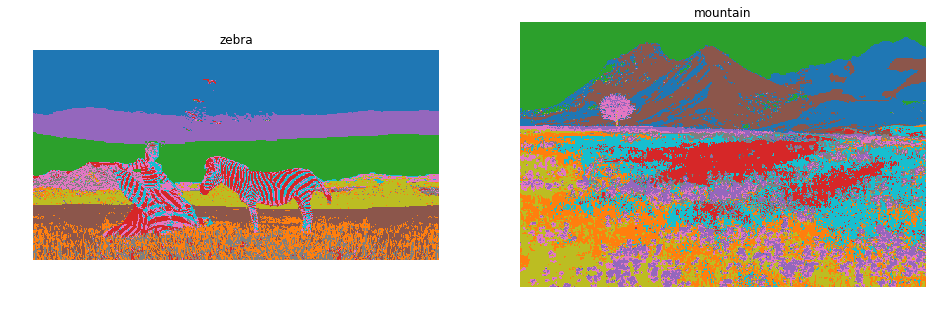

In [28]:
fig = plt.figure(figsize=(16,6))
ax2 = fig.add_subplot(1,2,1)
ax2.imshow( lab_zebra_cluster , cmap="tab10" )
ax2.set_title("zebra")
ax2.axis("off")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow( lab_mountain_cluster , cmap="tab10")
ax2.set_title("mountain")
ax2.axis("off")
plt.savefig("2-a-2.png")
plt.show()

### Texture segmentation
We now consider the use of texture information for image segmentation. For simplicity, please convert the color images into grayscale ones,before extracting image textural features via the provided flter bank. As a result, you
would produce n = w \* h 38-dimensional features, each dimension corresponds to a
particular \*lter response. Similarly, please perform k-means clustering\* to cluster these
n features into k different groups.
    
(i) Please plot the texture segmentation results for both images, as depicted in Fig. 1b.
    
(ii) Combine both color and texture features (3 + 38 = 41-dimensional features) for image segmentation. Repeat the above clustering procedure and plot your segmentation results. (*Note that when calculating filter responses, please use symmetric padding to deal with pixels near image boundaries. Please use k = 6 and maximum number of iterations = 1000 for both zebra.jpg and mountain.jpg.)

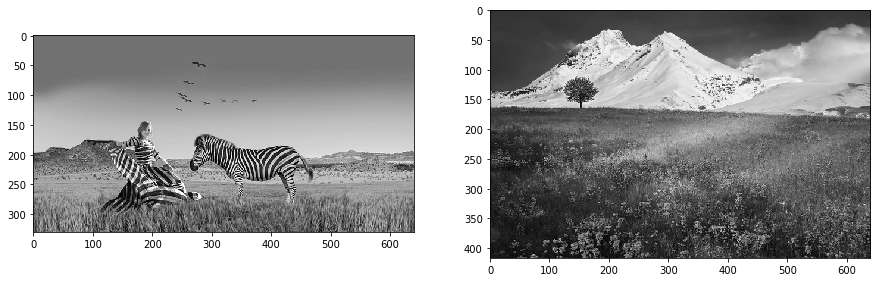

In [8]:
## turn gray
g_mountain = image_color.rgb2gray(mountain)
g_zebra = image_color.rgb2gray(zebra)

fig = plt.figure( figsize=(15,12) )
ax = fig.add_subplot( 1,2,2 )
ax.imshow( g_mountain , cmap="gray" )
ax = fig.add_subplot( 1,2,1 )
ax.imshow( g_zebra , cmap="gray" )


In [9]:
def conv_filter( arr , f , s_list , index):
    l_row , l_col = arr.shape[0:2]
    texture_img = np.zeros(shape=[l_row , l_col,1 ])
    ## Padding = Symmetric padding
    arr = np.lib.pad( arr , pad_width=[(24,24) , (24,24)] , mode="symmetric" )
    
    ## convolution
    for i in range(l_row):
        for j in range(l_col):
            texture_img[i,j,0] = np.sum(arr[i:i+49,j:j+49]*f)

    s_list[index]=texture_img
            

def conv_process( arr , my_filter):
    manager = Manager()
    share_list = manager.list( range(my_filter.shape[-1]) )

    job_list = []
    for i in range(38):
        input_config = dict( arr=arr , f=my_filter[:,:,i] , s_list=share_list , index=i )
        p = Process(target=conv_filter , kwargs=input_config)
        p.start()
        job_list.append( p )

    for j in job_list:
        j.join()

    return np.concatenate( share_list , axis=-1 )

In [10]:
filter_g_zebra = conv_process( g_zebra , filterBank )
filter_g_mountain = conv_process( g_mountain , filterBank )
print("Finish convolution\n" )

texture_zebra_cluster = produce_pixel_label(filter_g_zebra  , n_cluster=6 , size=38)
texture_mountain_cluster = produce_pixel_label(filter_g_mountain , n_cluster=6 , size=38)
print("Finish kmeans on filter image")

Finish convolution

Finish kmeans on filter image


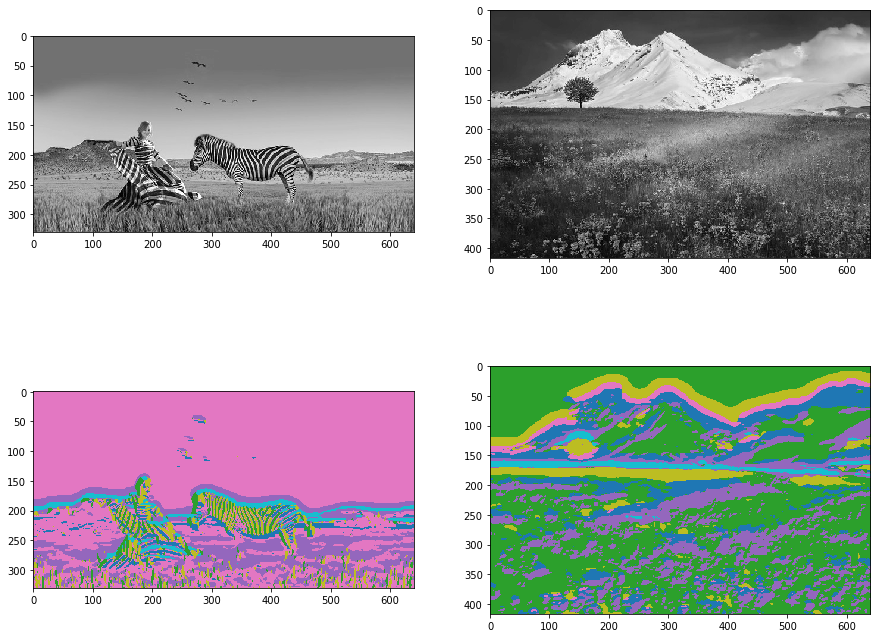

In [11]:
fig = plt.figure( figsize=(15,12) )
ax = fig.add_subplot( 2,2,2 )
ax.imshow( g_mountain , cmap="gray" )
ax = fig.add_subplot( 2,2,1 )
ax.imshow( g_zebra , cmap="gray" )
ax = fig.add_subplot( 2,2,4 )
ax.imshow( texture_mountain_cluster , cmap="tab10" )
ax = fig.add_subplot( 2,2,3 )
ax.imshow( texture_zebra_cluster , cmap="tab10" )


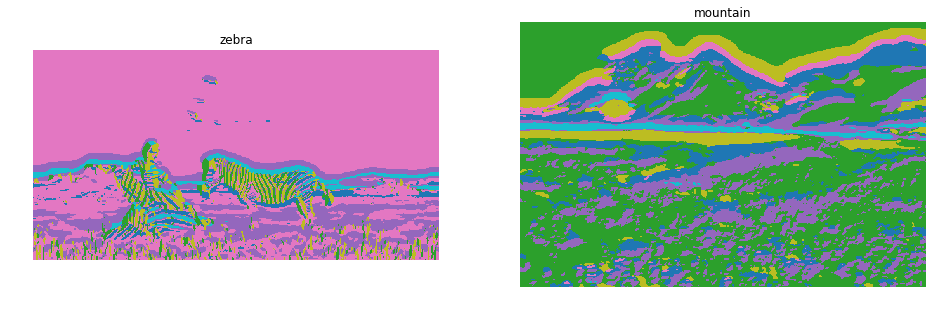

In [29]:
fig = plt.figure(figsize=(16,6))
ax2 = fig.add_subplot(1,2,1)
ax2.imshow( texture_zebra_cluster , cmap="tab10" )
ax2.set_title("zebra")
ax2.axis("off")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow( texture_mountain_cluster , cmap="tab10")
ax2.set_title("mountain")
ax2.axis("off")
plt.savefig("2-b-1.png")
plt.show()

In [12]:
all_info_zebra = np.concatenate( [lab_zebra , filter_g_zebra] , axis=-1 )
all_info_mountain = np.concatenate( [lab_mountain , filter_g_mountain] , axis=-1 )

all_zebra_cluster = produce_pixel_label( all_info_zebra , n_cluster=6 , size=38+3 )
all_mountain_cluster = produce_pixel_label( all_info_mountain , n_cluster=6 , size=38+3 )
print( "Clust by 38+3 dimension (filter + RGB) done" )

Clust by 38+3 dimension (filter + RGB) done


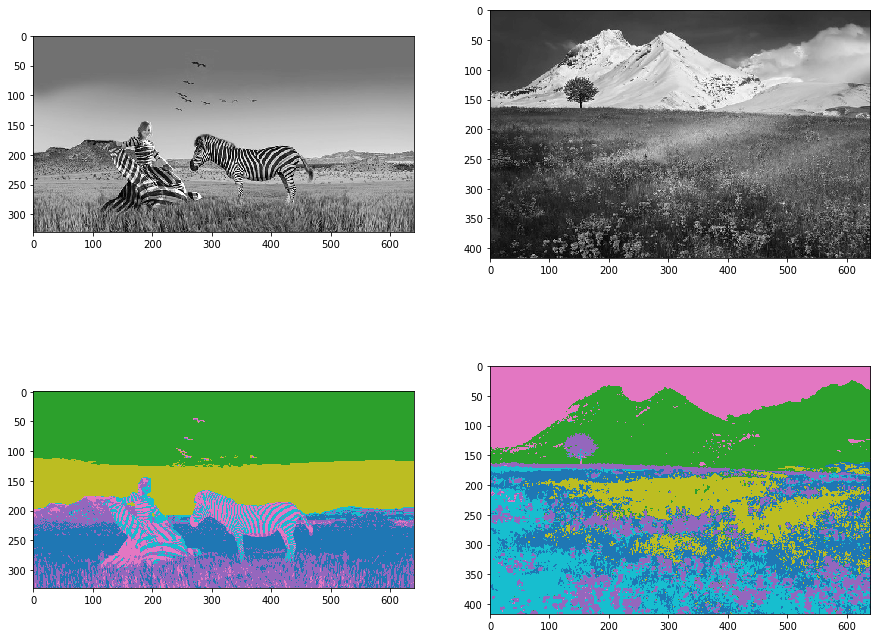

In [13]:
fig = plt.figure( figsize=(15,12) )
ax = fig.add_subplot( 2,2,2 )
ax.imshow( g_mountain , cmap="gray" )
ax = fig.add_subplot( 2,2,1 )
ax.imshow( g_zebra , cmap="gray" )
ax = fig.add_subplot( 2,2,4 )
ax.imshow( all_mountain_cluster , cmap="tab10" )
ax = fig.add_subplot( 2,2,3 )
ax.imshow( all_zebra_cluster , cmap="tab10" )


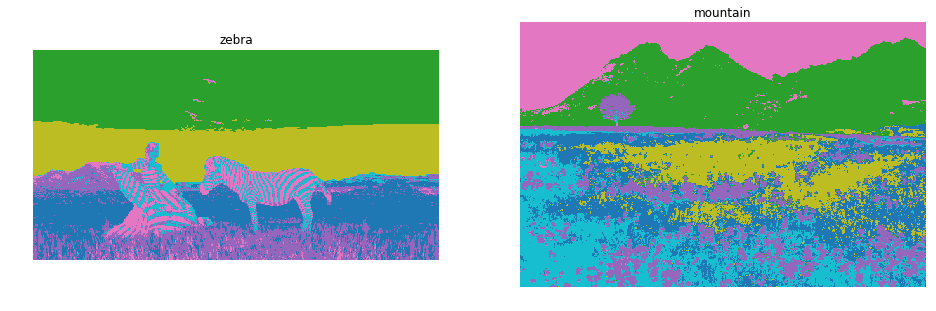

In [30]:
fig = plt.figure(figsize=(16,6))
ax2 = fig.add_subplot(1,2,1)
ax2.imshow(  all_zebra_cluster , cmap="tab10" )
ax2.set_title("zebra")
ax2.axis("off")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow( all_mountain_cluster , cmap="tab10")
ax2.set_title("mountain")
ax2.axis("off")
plt.savefig("2-b-2.png")
plt.show()